In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter

In [2]:
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style("whitegrid")

In [3]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [4]:
def plot(df, omega, title, alpha=0.5, stylek=False):
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(18, 8)
    
    dfx = df[df["omega"] == omega]
    if stylek:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    else:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    g2.set_yscale("log")
    g2.set_xscale("log")
    
    
    fig.suptitle(title)
    xlabel = "Num of k-mers"
    ylabel = "Time to process a window, microseconds"
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    
    #return fig

In [103]:
palette = sns.color_palette("Set2", 6)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961)]

In [104]:
colors = {
    'bb': palette[1],
    'dc': palette[0],
    'dccw': palette[2],
    'bbe': palette[5],
    'bl': palette[4],
}
white = "#ffffff"

In [6]:
def read_dataset(filename):
    df = pd.read_csv(filename)
    df["time"] += 1
    df["num_kmers"] += 1
    df["k"] = df["k"].astype(int)
    df["avg"] = df["time"] / df["num_kmers"]
    return df

In [7]:
# Average time per window of size Zbase (+- delta%) for different k
def plot1(df, Zbase, delta, ax, **kwargs):
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    
    Delta = Zbase / 100 * delta
    dfb = df[df["num_kmers"].between(Zbase - Delta, Zbase + Delta)]
    
    g = sns.lineplot(data=dfb, x="k", y="time", hue="alg", marker='o', palette=palette, ax=ax, legend=legend)
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    g.set_yscale("log")
    ytext = "Mean running time per window, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    g.set_title(title)
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g
    

In [8]:
def plot1_collection(df, **kwargs):
    z_values = [10, 100, 1000, 10000]
    delta = 1
    num_plots = len(z_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1, num_plots)

    for i, z in enumerate(z_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot1(df, z, delta, ax[i], ylabel=ylabel, legend=legend, title=r"$|\mathcal{Z}|\approx$" + str(z))

    plt.tight_layout()
    #return fig

In [120]:
# Mean time per window with differenet number of alive k-mers (fixed k), a rarefied plot
def plot2(df, k, ax=None, **kwargs):
    sample_size = kwargs.get("sample_size", 5000)
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    
    dfk = df if all_k else df[df["k"] == k]
    dfg = dfk.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
    
    max_num_kmers = dfk["num_kmers"].max()
    log_max_num_kmers = np.log10(max_num_kmers)
    
    space = np.linspace(1, max_num_kmers, num=sample_size)
    logspace = np.logspace(1, log_max_num_kmers, num=sample_size)
    
    #space = list(sorted(dfk["num_kmers"].unique()))
    
    if logy:
        df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
    else:
        df_rarefied = dfg[dfg["num_kmers"].isin(space)]

    num_algs = len(df_rarefied["alg"].unique())
    pal = palette[:num_algs]
    if ax:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', ax=ax, palette=colors, legend=legend, edgecolor=None)#edgecolor="black")
    else:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', palette=colors, legend=legend)
    g.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    
    if logy:
        g.set_xscale("log")
        g.set_yscale("log")
        
    g.set_title(title)
    
    # remove borders
    sns.despine()
    
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g


In [121]:
def plot2_collection(df, logy=False, **kwargs):    
    filename = kwargs.get("filename", None)
    sample_size = kwargs.get("sample_size", 5000)
    k_values = kwargs.get("k_values", [8, 10, 12])
    
    num_plots = len(k_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, k in enumerate(k_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot2(df, k, ax[i], ylabel=ylabel, legend=legend, title="$k=$" + str(k), sample_size=sample_size, logy=logy)

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)


In [60]:
def plot_mean_time(dfs, **kwargs):    
    logy = kwargs.get("logy", True)
    filename = kwargs.get("filename", None)
    sample_size = kwargs.get("sample_size", 500)
    k = kwargs.get("k", 10)

    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot2(df, k, ax[i], ylabel=ylabel, legend=legend, title=names[i], sample_size=sample_size, logy=logy)

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)

In [97]:
# Total time needed to preprocess a dataset for different values of k (fixed omega)
def plot3(df, ax, **kwargs):
    sns.set(rc={'figure.figsize':(7, 5)})
    sns.set_style("white")

    filename = kwargs.get("filename", None)
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    title = kwargs.get("title", "")
    
    df_sum = df.groupby(["k", "alg"]).sum().reset_index()

    if ax:
        g = sns.lineplot(data=df_sum, x="k", y="time", hue="alg", ax=ax, palette=colors, marker='o', markersize=6, legend=legend)
    else:
        g = sns.lineplot(data=df_sum, x="k", y="time", hue="alg", palette=colors, marker='o', markersize=6, legend=legend)
    
    ytext = "Total time for the dataset, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    g.set_title(title)
    
    g.set_yscale("log")
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    # remove borders
    sns.despine()
    
    if filename:
        plt.savefig(filename)

In [88]:
def plot_total_time(dfs, **kwargs):    
    logy = kwargs.get("logy", True)
    filename = kwargs.get("filename", None)
    sample_size = kwargs.get("sample_size", 500)
    k = kwargs.get("k", 10)

    names, datasets = zip(*dfs)
    num_plots = len(names)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("white")

    fig, ax = plt.subplots(1, num_plots)

    for i, df in enumerate(datasets):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot3(df, ax[i], ylabel=ylabel, legend=legend, title=names[i], sample_size=sample_size, logy=logy)

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)

### Neotrop

Measurements made for 100 random ghost nodes of Neotrop. Nodes are the same for both algorithms. All windows of the alignment are considered for every node. Time measurements: microseconds per window

In [25]:
neotrop = read_dataset("results/neotrop-dccw.csv")

### D155 (HCV)

100 random ghost nodes

In [26]:
d155 = read_dataset("results/d155-dccw.csv")

### Random data

Alignment length = 1000

In [27]:
random = read_dataset("results/random-dccw.csv")

In [68]:
dfs = list(zip(["Neotrop", "D155", "Random"], [neotrop, d155, random]))

# Plots for the paper
## Plot 1: fix k, vary |Z|. Mean running time

Let's fix k and see how time depends on the size of |Z|. For one value of |Z| on X-axis, show the mean time of generating such windows.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


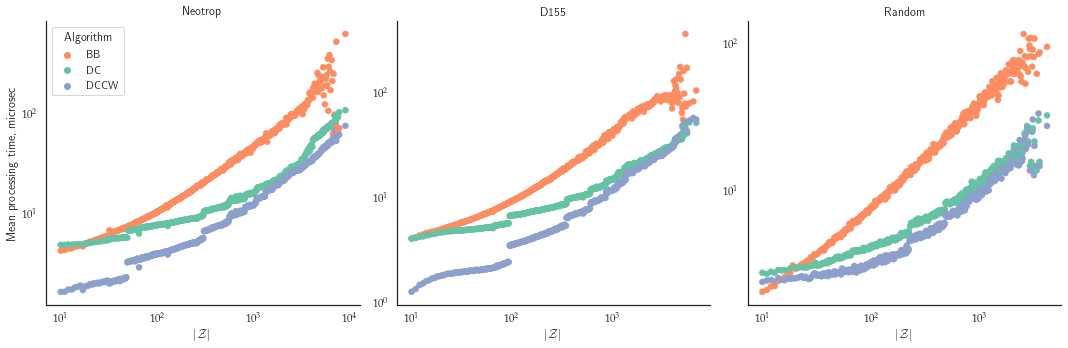

In [69]:
plot_mean_time(dfs, filename="img/mean-time-k10.eps")

## Plot 2: total running time per dataset (fixed k and omega)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


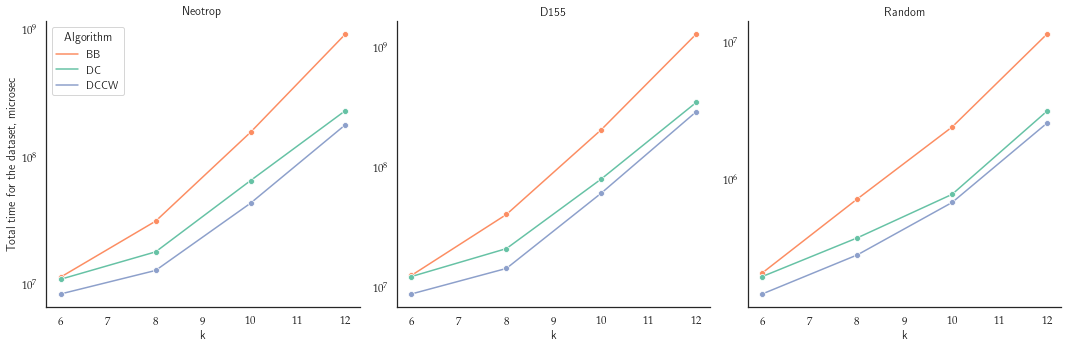

In [98]:
plot_total_time(dfs, filename="img/total-time-k10.eps")

# Other things (may go to the appendix)

## Plots per dataset

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


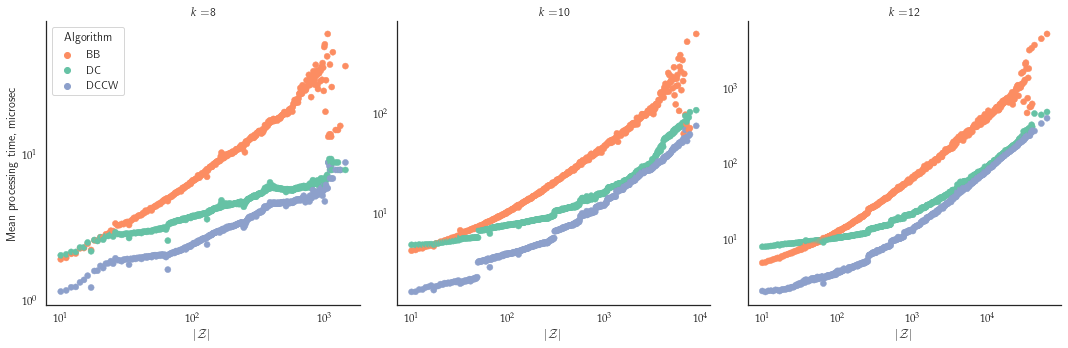

In [112]:
plot2_collection(neotrop, True, sample_size=500, filename="img/neotrop.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


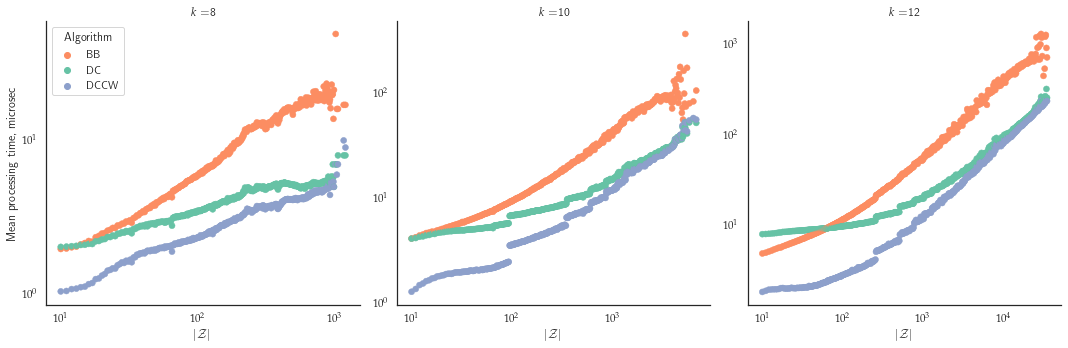

In [113]:
plot2_collection(d155, True, sample_size=500, filename="img/d155.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


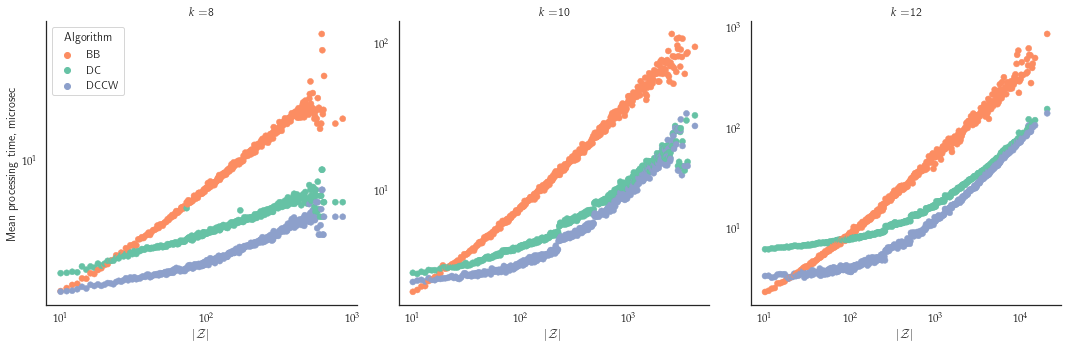

In [114]:
plot2_collection(random, True, sample_size=500, filename="img/random.eps")

## BB with sorted columns

In [101]:
neotrop_bbe = read_dataset("results/neotrop-bbe.csv")

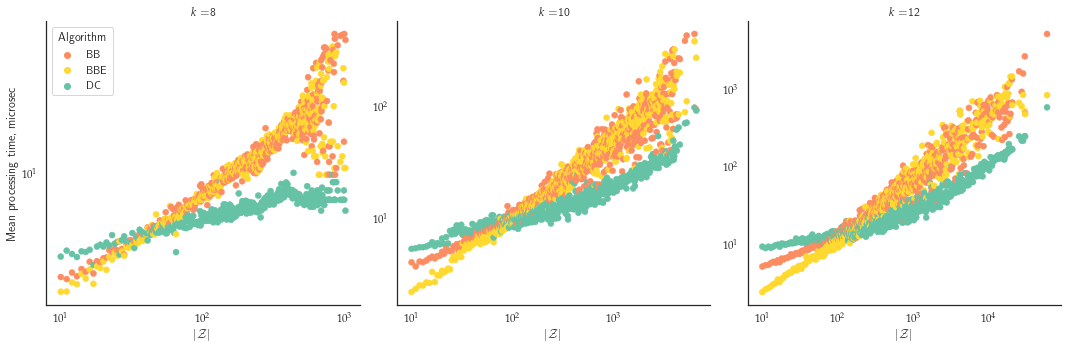

In [105]:
plot2_collection(neotrop_bbe, True, sample_size=1000)

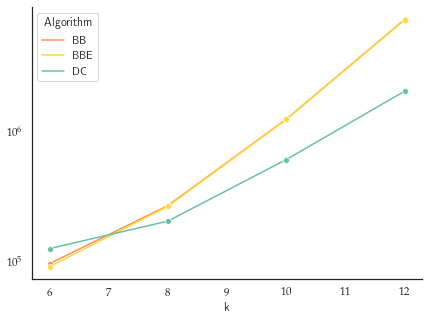

In [108]:
plot3(neotrop_bbe, None, sample_size=1000, legend=True)

## The same for $\omega = 1.0$

In [116]:
neotrop_bbe_o1 = read_dataset("results/neotrop-o1-bbe.csv")

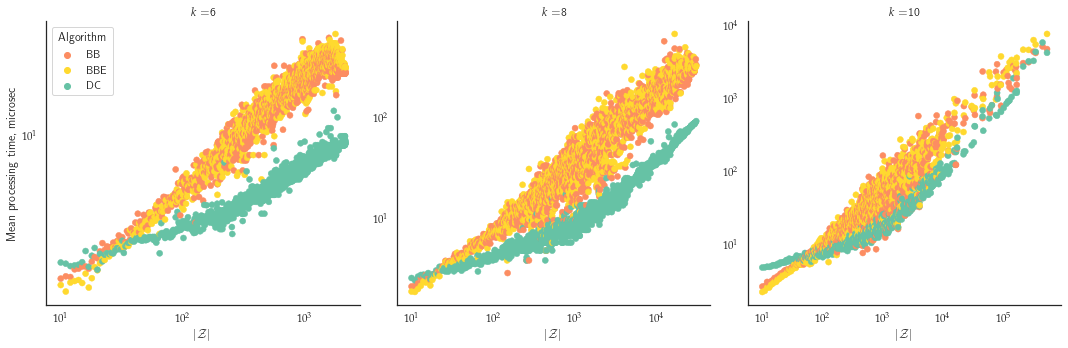

In [123]:
plot2_collection(neotrop_bbe_o1, True, sample_size=5000, k_values=[6, 8, 10])

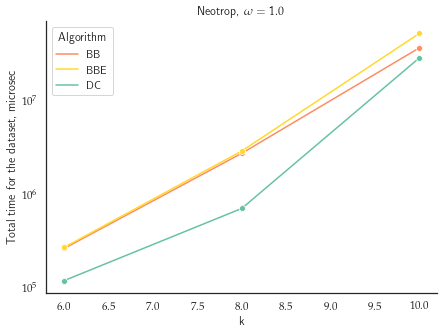

In [126]:
plot3(neotrop_bbe_o1, None, sample_size=5000, legend=True, ylabel=True, title="Neotrop, $\omega = 1.0$")

## The same for random data, $\omega = 1.5$

In [128]:
random_bbe = read_dataset("results/random-bbe.csv")

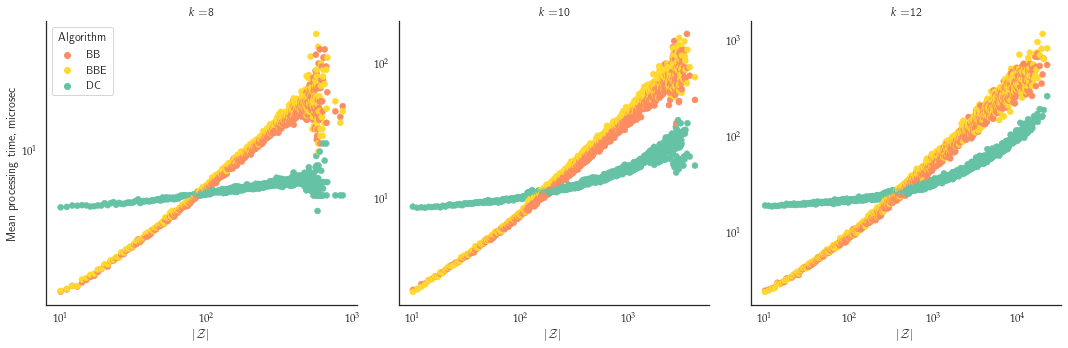

In [129]:
plot2_collection(random_bbe, True, sample_size=2000)

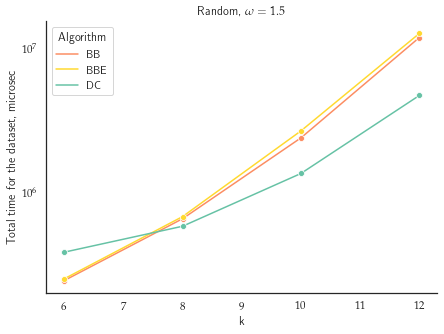

In [130]:
plot3(random_bbe, None, sample_size=5000, legend=True, ylabel=True, title="Random, $\omega = 1.5$")

## Output baseline

How long does it take to just output the required number of k-mers as the result (i.e., write to the output array)

In [99]:
neotrop_bl = read_dataset("results/neotrop-baseline.csv")

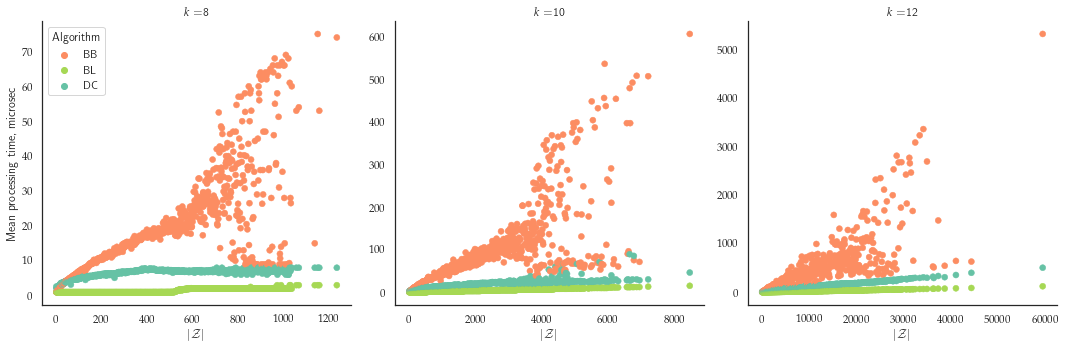

In [131]:
plot2_collection(neotrop_bl, False, sample_size=1000)

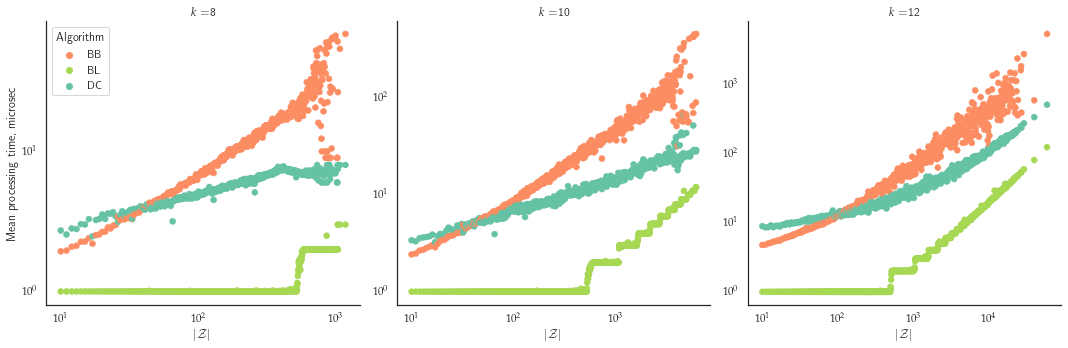

In [132]:
plot2_collection(neotrop_bl, True, sample_size=1000)